In [1]:
STATE_LIST = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

from folktables import ACSDataSource, ACSIncome
import numpy as np
import pandas as pd
from scipy.stats import beta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import sklearn.preprocessing as preprocessing
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from responsibly.fairness.interventions.threshold import find_thresholds



data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = pd.DataFrame()

for state in STATE_LIST:
    acs_data = pd.concat([acs_data, data_source.get_data(states=[state], download=False)])

features, label, group = ACSIncome.df_to_numpy(acs_data)

In [3]:
fair_constarint = ['single', 'min_cost', 'independence', 'fnr']
fair = 3

# Define true parameter settings
min_1_group1 = 0
max_1_group1 = 1
min_0_group1 = 0
max_0_group1 = 1
min_1_group0 = 0
max_1_group0 = 1
min_0_group0 = 0
max_0_group0 = 1

reference_quantile_0 = 0.6
reference_quantile_1 = 0.5
exploration_porb_group1 = 1
exploration_porb_group0 = 1
batchsize_init = 6000
batchsize_additional = 2000

# Defining other parameters
TP_group1 = 0
FP_group1 = 0
FN_group1 = 0
TN_group1 = 0
TP_group0 = 0
FP_group0 = 0
FN_group0 = 0
TN_group0 = 0

TP_oracle_group1 = 0 
FP_oracle_group1 = 0
FN_oracle_group1 = 0
TN_oracle_group1 = 0
TP_oracle_group0 = 0 
FP_oracle_group0 = 0
FN_oracle_group0 = 0
TN_oracle_group0 = 0

In [4]:
features.shape, label.shape

((1664500, 10), (1664500,))


In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, label, train_size = 0.99999, shuffle=True, random_state = 0)

classifier = LogisticRegression().fit(X_train, y_train)
prob = classifier.predict_proba(features)[:,1]

original = pd.DataFrame(features)
original["Prob"] = prob
original['Target'] = label
original['Race'] = group
original

# Split four groups data for true parameters mapping
grouphigh_label1 = original[(original["Target"]==True) & (original["Race"]==1)]["Prob"]
grouphigh_label0 = original[(original["Target"]==False) & (original["Race"]==1)]["Prob"]
grouplow_label1 = original[(original["Target"]==True) & (original["Race"]!=1)]["Prob"]
grouplow_label0 = original[(original["Target"]==False) & (original["Race"]!=1)]["Prob"]

# Reindex four groups data
grouphigh_label1.reset_index(inplace=True, drop=True)
grouphigh_label0.reset_index(inplace=True, drop=True)
grouplow_label1.reset_index(inplace=True, drop=True)
grouplow_label0.reset_index(inplace=True, drop=True)

a,b1_true_group1,c,d = beta.fit(grouphigh_label1,floc=min_1_group1,fscale=max_1_group1-min_1_group1)
a,b0_true_group1,c,d = beta.fit(grouphigh_label0,floc=min_0_group1,fscale=max_0_group1-min_0_group1)
a,b1_true_group0,c,d = beta.fit(grouplow_label1,floc=min_1_group0,fscale=max_1_group0-min_1_group0)
a,b0_true_group0,c,d = beta.fit(grouplow_label0,floc=min_0_group0,fscale=max_0_group0-min_0_group0)

x = np.arange(0.01,10,0.01)
def f(alpha):
    return abs(beta.cdf(np.quantile(grouphigh_label1,reference_quantile_1), alpha, b1_true_group1, loc=min_1_group1, scale=max_1_group1-min_1_group1) - reference_quantile_1)
a1_true_group1 = np.argmin(f(x))*0.01

def f(alpha):
    return abs(beta.cdf(np.quantile(grouphigh_label0,reference_quantile_0), alpha, b0_true_group1, loc=min_0_group1, scale=max_0_group1-min_0_group1) - reference_quantile_0)
a0_true_group1 = np.argmin(f(x))*0.01

def f(alpha):
    return abs(beta.cdf(np.quantile(grouplow_label1,reference_quantile_1), alpha, b1_true_group0, loc=min_1_group0, scale=max_1_group0-min_1_group0) - reference_quantile_1)
a1_true_group0 = np.argmin(f(x))*0.01

def f(alpha):
    return abs(beta.cdf(np.quantile(grouplow_label0,reference_quantile_0), alpha, b0_true_group0, loc=min_0_group0, scale=max_0_group0-min_0_group0) - reference_quantile_0)
a0_true_group0 = np.argmin(f(x))*0.01

print (a1_true_group1,b1_true_group1,a0_true_group1,b0_true_group1,
       a1_true_group0,b1_true_group0,a0_true_group0,b0_true_group0)

2.83 2.157321192187306 1.22 2.567436922540754 2.3000000000000003 2.529503761497414 1.03 3.296952098693569


In [6]:
# Select first (Initial_fit_portion) rows to find initial assumed distribution
Initial_fit_portion = 0.03
X_train, X_test, y_train, y_test = train_test_split(features, label, train_size = Initial_fit_portion, shuffle=True, random_state = 0)

classifier = LogisticRegression().fit(X_train, y_train)
prob = classifier.predict_proba(features)[:,1]
original["Prob"] = prob
First_n_data = original.head(round(Initial_fit_portion*len(features)))
Initialhigh_label1 = First_n_data[(First_n_data["Target"]==True) & (First_n_data["Race"]==1)]["Prob"]
Initialhigh_label0 = First_n_data[(First_n_data["Target"]==False) & (First_n_data["Race"]==1)]["Prob"]
Initiallow_label1 = First_n_data[(First_n_data["Target"]==True) & (First_n_data["Race"]!=1)]["Prob"]
Initiallow_label0 = First_n_data[(First_n_data["Target"]==False) & (First_n_data["Race"]!=1)]["Prob"]

# Reindex
Initialhigh_label1.reset_index(inplace=True, drop=True)
Initialhigh_label0.reset_index(inplace=True, drop=True)
Initiallow_label1.reset_index(inplace=True, drop=True)
Initiallow_label0.reset_index(inplace=True, drop=True)

# Fix beta parameter
b1_init_group1 = b1_true_group1
b0_init_group1 = b0_true_group1
b1_init_group0 = b1_true_group0
b0_init_group0 = b0_true_group0

b1_group1 = b1_init_group1
b0_group1 = b0_init_group1
b1_group0 = b1_init_group0
b0_group0 = b0_init_group0

# Find initial alpha parameter by fixing beta value
def f(alpha):
    return abs(beta.cdf(np.quantile(Initialhigh_label1,reference_quantile_1), alpha, b1_true_group1, loc=min_1_group1, scale=max_1_group1-min_1_group1) - reference_quantile_1)
a1_init_group1 = np.argmin(f(x))*0.01

def f(alpha):
    return abs(beta.cdf(np.quantile(Initialhigh_label0,reference_quantile_0), alpha, b0_true_group1, loc=min_0_group1, scale=max_0_group1-min_0_group1) - reference_quantile_0)
a0_init_group1 = np.argmin(f(x))*0.01

def f(alpha):
    return abs(beta.cdf(np.quantile(Initiallow_label1,reference_quantile_1), alpha, b1_true_group0, loc=min_1_group0, scale=max_1_group0-min_1_group0) - reference_quantile_1)
a1_init_group0 = np.argmin(f(x))*0.01

def f(alpha):
    return abs(beta.cdf(np.quantile(Initiallow_label0,reference_quantile_0), alpha, b0_true_group0, loc=min_0_group0, scale=max_0_group0-min_0_group0) - reference_quantile_0)
a0_init_group0 = np.argmin(f(x))*0.01

a1_group1 = a1_init_group1
a0_group1 = a0_init_group1
a1_group0 = a1_init_group0
a0_group0 = a0_init_group0
print (a1_group1,b1_group1,a0_group1,b0_group1,
       a1_group0,b1_group0,a0_group0,b0_group0)

2.7 2.157321192187306 1.28 2.567436922540754 2.22 2.529503761497414 1.16 3.296952098693569


In [7]:
# Find the confusion matrix given threshold
def CM(Y_test,y_pred,threshold):
    # The Confusion Matrix given a threshold
    y_pred = np.where(y_pred>threshold,1,0)
    cm = pd.DataFrame(confusion_matrix(Y_test,y_pred))
    cm.rename(columns={0:'Pred_neg', 1:'Pred_pos'},
         index = {0:'Actual_neg',1:'Actual_pos'},inplace=True)
    cm['Total'] = cm['Pred_neg'] + cm['Pred_pos'] 
    rowsum = cm.sum()
    rowsum.name = 'Total'
    cm = cm.append(rowsum.transpose())
    
    # TP/TN/FP/FN/TPR/FPR
    P = cm['Total']['Actual_pos']
    N = cm['Total']['Actual_neg']
    TP = cm['Pred_pos']['Actual_pos']
    TN = cm['Pred_neg']['Actual_neg']
    FP = cm['Pred_pos']['Actual_neg']
    FN = cm['Pred_neg']['Actual_pos']
    TPR = np.round(TP/P,2)
    FPR = np.round(FP/N,2)
    return(cm, TPR, FPR)

# Define the cost matrix
COST_MATRIX = [[0, -3/6],
               [0,  3/6]]

In [8]:
# Find fair classifier for the inital training set

# Find the parameters proportions, base_rate and base_rates 
proportions = {'White': (len(Initialhigh_label1) + len(Initialhigh_label0))/(len(Initialhigh_label1) + len(Initialhigh_label0) + len(Initiallow_label1) + len(Initiallow_label0)), 
               'Non-White': 1 - (len(Initialhigh_label1) + len(Initialhigh_label0))/(len(Initialhigh_label1) + len(Initialhigh_label0) + len(Initiallow_label1) + len(Initiallow_label0))}
base_rate = (len(Initialhigh_label1) + len(Initiallow_label1))/(len(Initialhigh_label1) + len(Initialhigh_label0) + len(Initiallow_label1) + len(Initiallow_label0))
d = {'White': len(Initialhigh_label1)/(len(Initialhigh_label1) + len(Initialhigh_label0)), 'Non-White': len(Initiallow_label1)/(len(Initiallow_label1) + len(Initiallow_label0))}
base_rates = pd.Series(data = d, index = ['White','Non-White'])

# Find the ROC curve by construting confusion matrix 
yprob1 = First_n_data[First_n_data["Race"]==1]["Prob"]
yprob0 = First_n_data[First_n_data["Race"]!=1]["Prob"]
  
TPR1 = []
FPR1 = []
threshold1 = []
for threshold in range(201,0,-1):
    cm, TPR, FPR = CM(First_n_data[First_n_data["Race"]==1]["Target"],yprob1,threshold/200)
    TPR1 = TPR1 + [TPR]
    FPR1 = FPR1 + [FPR]
    threshold1 = threshold1 + [threshold/200]
TPR1 = np.array(TPR1)
FPR1 = np.array(FPR1)
threshold1 = np.array(threshold1)

TPR0 = []
FPR0 = []
threshold0 = []
for threshold in range(201,0,-1):
    cm, TPR, FPR = CM(First_n_data[First_n_data["Race"]!=1]["Target"],yprob0,threshold/200)
    TPR0 = TPR0 + [TPR]
    FPR0 = FPR0 + [FPR]
    threshold0 = threshold0 + [threshold/200]
TPR0 = np.array(TPR0)
FPR0 = np.array(FPR0)
threshold0 = np.array(threshold0)

# Find the parameter rocs 
rocs = {'White': (FPR1, TPR1, threshold1), 'Non-White': (FPR0, TPR0,threshold0)}

# Find the initial fairness classifier_1 and classifier_2 
thresholds_data = find_thresholds(rocs, proportions, base_rate, base_rates, COST_MATRIX)
if fair != 0:
    classifier_group1 = thresholds_data[fair_constarint[fair]][0]['White']
    classifier_group0 = thresholds_data[fair_constarint[fair]][0]['Non-White']
else: 
    classifier_group1 = thresholds_data[fair_constarint[fair]][0]
    classifier_group0 = thresholds_data[fair_constarint[fair]][0]
#print (classifier_group1, classifier_group0)

In [9]:
# Find oracle fair classifier for the entire set

# Find the parameters proportions, base_rate and base_rates 
proportions = {'White': (len(grouphigh_label1) + len(grouphigh_label0))/(len(grouphigh_label1) + len(grouphigh_label0) + len(grouplow_label1) + len(grouplow_label1)), 
               'Non-White': 1 - (len(grouphigh_label1) + len(grouphigh_label0))/(len(grouphigh_label1) + len(grouphigh_label0) + len(grouplow_label1) + len(grouplow_label1))}
base_rate = (len(grouphigh_label1) + len(grouplow_label1))/(len(grouphigh_label1) + len(grouphigh_label0) + len(grouplow_label1) + len(grouplow_label1))
d = {'White': len(grouphigh_label1)/(len(grouphigh_label1) + len(grouphigh_label0)), 'Non-White': len(grouplow_label1)/(len(grouplow_label1) + len(grouplow_label0))}
base_rates = pd.Series(data = d, index = ['White','Non-White'])

# Find the ROC curve by construting confusion matrix 
yprob1 = original[original["Race"]==1]["Prob"]
yprob0 = original[original["Race"]!=1]["Prob"]

TPR1 = []
FPR1 = []
threshold1 = []
for threshold in range(201,0,-1):
    cm, TPR, FPR = CM(original[original["Race"]==1]["Target"],yprob1,threshold/200)
    TPR1 = TPR1 + [TPR]
    FPR1 = FPR1 + [FPR]
    threshold1 = threshold1 + [threshold/200]
TPR1 = np.array(TPR1)
FPR1 = np.array(FPR1)
threshold1 = np.array(threshold1)

TPR0 = []
FPR0 = []
threshold0 = []
for threshold in range(201,0,-1):
    cm, TPR, FPR = CM(original[original["Race"]!=1]["Target"],yprob0,threshold/200)
    TPR0 = TPR0 + [TPR]
    FPR0 = FPR0 + [FPR]
    threshold0 = threshold0 + [threshold/200]
TPR0 = np.array(TPR0)
FPR0 = np.array(FPR0)
threshold0 = np.array(threshold0)

# Find the parameter rocs 
rocs = {'White': (FPR1, TPR1, threshold1), 'Non-White': (FPR0, TPR0,threshold0)}

# Find the initial fairness classifier_1 and classifier_2 
thresholds_data = find_thresholds(rocs, proportions, base_rate, base_rates, COST_MATRIX)
if fair != 0:
    classifier_oracle_value_1 = thresholds_data[fair_constarint[fair]][0]['White']
    classifier_oracle_value_0 = thresholds_data[fair_constarint[fair]][0]['Non-White']
else: 
    classifier_oracle_value_1 = thresholds_data[fair_constarint[fair]][0]
    classifier_oracle_value_0 = thresholds_data[fair_constarint[fair]][0]
#print (classifier_oracle_value_1, classifier_oracle_value_0)

In [10]:
print (classifier_group1, classifier_group0)
print (classifier_oracle_value_1, classifier_oracle_value_0)

0.585 0.484
0.48 0.385


In [11]:
# Find the LB_1 and UB_1 with fair classifier(Using alpha = 60 for label 0 and median for label 1)
temp = 2*beta.cdf(beta.ppf(reference_quantile_0,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1),a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1) -\
            beta.cdf(classifier_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)
LB_group1 = max(min_0_group1, float(beta.ppf(temp,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)))

temp = 2*beta.cdf(beta.ppf(reference_quantile_1,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1),a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1) -\
            beta.cdf(LB_group1,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)
UB_group1 = min(max_1_group1, float(beta.ppf(temp,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)))

# Find the LB_0 and UB_0 with fair classifier(Using alpha = 60 for label 0 and median for label 1)
temp = 2*beta.cdf(beta.ppf(reference_quantile_0,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0),a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0) -\
            beta.cdf(classifier_group0,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0)
LB_group0 = max(min_0_group0, float(beta.ppf(temp,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0)))

temp = 2*beta.cdf(beta.ppf(reference_quantile_1,a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0),a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0) -\
            beta.cdf(LB_group0,a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0)
UB_group0 = min(max_1_group0, float(beta.ppf(temp,a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0)))
print (LB_group1, UB_group1, LB_group0, UB_group0)

0.21037415954842437 0.8742951487654165 0.1456411723018272 0.8041116541374184


In [12]:
from sklearn.utils import shuffle
data_1_group1 = Initialhigh_label1
data_0_group1 = Initialhigh_label0
data_1_group0 = Initiallow_label1
data_0_group0 = Initiallow_label0

Rest_data = original.tail(round((1-Initial_fit_portion)*len(features)))[["Prob","Target","Race"]]
Rest_data.reset_index(inplace=True, drop=True)

info = pd.DataFrame(columns = ['True Label','Values','Decision','RP_1_group1','RP_0_group1',
                                      'Classifier_group1','Explore_Prob_group1','RP_1_group0','RP_0_group0',
                                      'Classifier_group0','Explore_Prob_group0','Alpha_1_group1','Alpha_0_group1',
                                       'Alpha_1_group0','Alpha_0_group0','Regret','Race'])
info[["Values","True Label","Race"]] = Rest_data
info = shuffle(info)
info.reset_index(inplace=True, drop=True)

In [13]:
i = 0
# Create loop for updating
while (i <= len(info)-1):
    
    if i<= (len(grouphigh_label1) + len(grouphigh_label0) + len(grouplow_label1) + len(grouplow_label1)):
        batchsize = batchsize_init
    else: 
        batchsize = batchsize_additional
        
    data_1_trun_group1 = []
    data_0_trun_group1 = []
    data_1_trun_group0 = []
    data_0_trun_group0 = []
    
    # find quantile of reference point including label 0 tail for advantage group
    portion_right0_group1 = (beta.sf(beta.ppf(reference_quantile_0,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1),
                                    a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)
                     /beta.sf(LB_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1))
    portion_left0_group1 = 1 - portion_right0_group1
    
    portion_right1_group1 = (beta.sf(beta.ppf(reference_quantile_1,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1),
                                    a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)
                     /beta.sf(LB_group1,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1))
    portion_left1_group1 = 1 - portion_right1_group1
    
    # find quantile of reference point including label 0 tail for disadvantage group
    portion_right0_group0 = (beta.sf(beta.ppf(reference_quantile_0,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0),
                                    a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0)
                     /beta.sf(LB_group0,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0))
    portion_left0_group0 = 1 - portion_right0_group0
    
    portion_right1_group0 = (beta.sf(beta.ppf(reference_quantile_1,a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0),
                                    a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0)
                     /beta.sf(LB_group0,a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0))
    portion_left1_group0 = 1 - portion_right1_group0
    
    k1_group1 = len(data_1_trun_group1)
    k0_group1 = len(data_0_trun_group1)
    k1_group0 = len(data_1_trun_group0)
    k0_group0 = len(data_0_trun_group0)
    #loop into each batch
    while ((min(k1_group1, k0_group1, k1_group0, k0_group0) <= batchsize) & (i <= len(info)-1)):
        
        if info.loc[i,'Race'] == 1:
        
            # Make decisions
            if (info.loc[i,'Values'] >= classifier_group1) & (info.loc[i,'Values']<=UB_group1):
                info.loc[i,'Decision'] = 1
            elif (info.loc[i,'Values'] < classifier_group1) & (info.loc[i,'Values']>=LB_group1) & (np.random.uniform(size=1)<=exploration_porb_group1):
                info.loc[i,'Decision'] = 1
            elif (info.loc[i,'Values'] >= classifier_group1) & (info.loc[i,'Values']>UB_group1):
                info.loc[i,'Decision'] = 2
            elif (info.loc[i,'Values'] < classifier_group1) & (info.loc[i,'Values']<LB_group1):
                info.loc[i,'Decision'] = 3
            else:
                info.loc[i,'Decision'] = 0  

            # Record confusion matrix
            if (info.loc[i,'True Label']==1) & ((info.loc[i,'Decision']==1) or (info.loc[i,'Decision']==2)):
                TP_group1 += 1
            elif (info.loc[i,'True Label']==1) & ((info.loc[i,'Decision']==0) or (info.loc[i,'Decision']==3)):
                FN_group1 += 1
            elif (info.loc[i,'True Label']==0) & ((info.loc[i,'Decision']==0) or (info.loc[i,'Decision']==3)):
                TN_group1 += 1
            else:
                FP_group1 += 1

            # Record oracle matrix
            if (info.loc[i,'Values'] >= classifier_oracle_value_1) & (info.loc[i,'True Label']==1):
                TP_oracle_group1 += 1
            elif (info.loc[i,'Values'] >= classifier_oracle_value_1) & (info.loc[i,'True Label']==0):
                FP_oracle_group1 += 1
            elif (info.loc[i,'Values'] < classifier_oracle_value_1) & (info.loc[i,'True Label']==1):
                FN_oracle_group1 += 1
            else:
                TN_oracle_group1 += 1


            # Record label 1 information for updating
            if (info.loc[i,'True Label']==1) & ((info.loc[i,'Decision']==1) or (info.loc[i,'Decision']==2)):
                data_1_group1 = np.append(data_1_group1, info.loc[i,'Values'])
                if (((info.loc[i,'Values'] < classifier_group1) & (info.loc[i,'Decision']==1)) 
                   or ((info.loc[i,'Values'] >= classifier_group1) & (info.loc[i,'Decision']==1) & (np.random.uniform(size=1)<=exploration_porb_group1))):
                    data_1_trun_group1 = np.append(data_1_trun_group1, info.loc[i,'Values'])
            else:
                data_1_group1 = data_1_group1 
                data_1_trun_group1 = data_1_trun_group1


            # Record label 0 information for updating
            if (info.loc[i,'True Label']==0) & ((info.loc[i,'Decision']==1) or (info.loc[i,'Decision']==2)):
                data_0_group1 = np.append(data_0_group1, info.loc[i,'Values'])
                if (((info.loc[i,'Values'] < classifier_group1) & (info.loc[i,'Decision']==1)) 
                    or ((info.loc[i,'Values'] >= classifier_group1) & (np.random.uniform(size=1)<=exploration_porb_group1))):
                    data_0_trun_group1 = np.append(data_0_trun_group1, info.loc[i,'Values'])
            else:
                data_0_group1 = data_0_group1 
                data_0_trun_group1 = data_0_trun_group1
       
        else: # for non-white group
            
            # Make decisions
            if (info.loc[i,'Values'] >= classifier_group0) & (info.loc[i,'Values']<=UB_group0):
                info.loc[i,'Decision'] = 1
            elif (info.loc[i,'Values'] < classifier_group0) & (info.loc[i,'Values']>=LB_group0) & (np.random.uniform(size=1)<=exploration_porb_group0):
                info.loc[i,'Decision'] = 1
            elif (info.loc[i,'Values'] >= classifier_group0) & (info.loc[i,'Values']>UB_group0):
                info.loc[i,'Decision'] = 2
            elif (info.loc[i,'Values'] < classifier_group0) & (info.loc[i,'Values']<LB_group0):
                info.loc[i,'Decision'] = 3
            else:
                info.loc[i,'Decision'] = 0  

            # Record confusion matrix
            if (info.loc[i,'True Label']==1) & ((info.loc[i,'Decision']==1) or (info.loc[i,'Decision']==2)):
                TP_group0 += 1
            elif (info.loc[i,'True Label']==1) & ((info.loc[i,'Decision']==0) or (info.loc[i,'Decision']==3)):
                FN_group0 += 1
            elif (info.loc[i,'True Label']==0) & ((info.loc[i,'Decision']==0) or (info.loc[i,'Decision']==3)):
                TN_group0 += 1
            else:
                FP_group0 += 1

            # Record oracle matrix
            if (info.loc[i,'Values'] >= classifier_oracle_value_0) & (info.loc[i,'True Label']==1):
                TP_oracle_group0 += 1
            elif (info.loc[i,'Values'] >= classifier_oracle_value_0) & (info.loc[i,'True Label']==0):
                FP_oracle_group0 += 1
            elif (info.loc[i,'Values'] < classifier_oracle_value_0) & (info.loc[i,'True Label']==1):
                FN_oracle_group0 += 1
            else:
                TN_oracle_group0 += 1


            # Record label 1 information for updating
            if (info.loc[i,'True Label']==1) & ((info.loc[i,'Decision']==1) or (info.loc[i,'Decision']==2)):
                data_1_group0 = np.append(data_1_group0, info.loc[i,'Values'])
                if (((info.loc[i,'Values'] < classifier_group0) & (info.loc[i,'Decision']==1)) 
                   or ((info.loc[i,'Values'] >= classifier_group0) & (info.loc[i,'Decision']==1) & (np.random.uniform(size=1)<=exploration_porb_group0))):
                    data_1_trun_group0 = np.append(data_1_trun_group0, info.loc[i,'Values'])
            else:
                data_1_group0 = data_1_group0 
                data_1_trun_group0 = data_1_trun_group0


            # Record label 0 information for updating
            if (info.loc[i,'True Label']==0) & ((info.loc[i,'Decision']==1) or (info.loc[i,'Decision']==2)):
                data_0_group0 = np.append(data_0_group0, info.loc[i,'Values'])
                if (((info.loc[i,'Values'] < classifier_group0) & (info.loc[i,'Decision']==1)) 
                    or ((info.loc[i,'Values'] >= classifier_group0) & (np.random.uniform(size=1)<=exploration_porb_group0))):
                    data_0_trun_group0 = np.append(data_0_trun_group0, info.loc[i,'Values'])
            else:
                data_0_group0 = data_0_group0 
                data_0_trun_group0 = data_0_trun_group0
            
        k1_group1 = len(data_1_trun_group1)
        k0_group1 = len(data_0_trun_group1)
        k1_group0 = len(data_1_trun_group0)
        k0_group0 = len(data_0_trun_group0)
        i = i + 1
    
    # Record new mean value/RP and classifier
    info.loc[i-1,'RP_1_group1'] = np.quantile(data_1_trun_group1, portion_left1_group1)  #np.median(data_1_trun_group1) 
    info.loc[i-1,'RP_0_group1'] =  np.quantile(data_0_trun_group1, portion_left0_group1) 
    info.loc[i-1,'Classifier_group1'] = classifier_group1
    info.loc[i-1,'Regret'] = (FP_group1 + FN_group1)-(FP_oracle_group1 + FN_oracle_group1)
    info.loc[i-1,'Explore_Prob_group1'] = exploration_porb_group1
    
    info.loc[i-1,'RP_1_group0'] = np.quantile(data_1_trun_group0, portion_left1_group0)   #np.median(data_1_trun_group0)  
    info.loc[i-1,'RP_0_group0'] =  np.quantile(data_0_trun_group0, portion_left0_group0) 
    info.loc[i-1,'Classifier_group0'] = classifier_group0
    info.loc[i-1,'Explore_Prob_group0'] = exploration_porb_group0
    
    x = np.arange(0.01,10,0.01)
    # Reassign new values to parameters
    def f(alpha):
        return abs(beta.cdf(info.loc[i-1,'RP_1_group1'], alpha, b1_group1, loc=min_1_group1, scale=max_1_group1-min_1_group1) - reference_quantile_1)
    info.loc[i-1,'Alpha_1_group1'] = np.argmin(f(x))*0.01
    
    def f(alpha):
        return abs(beta.cdf(info.loc[i-1,'RP_0_group1'], alpha, b0_group1, loc=min_0_group1, scale=max_0_group1-min_0_group1) - reference_quantile_0)
    info.loc[i-1,'Alpha_0_group1'] = np.argmin(f(x))*0.01
    
    def f(alpha):
        return abs(beta.cdf(info.loc[i-1,'RP_1_group0'], alpha, b1_group0, loc=min_1_group0, scale=max_1_group0-min_1_group0) - reference_quantile_1)
    info.loc[i-1,'Alpha_1_group0'] = np.argmin(f(x))*0.01
    
    def f(alpha):
        return abs(beta.cdf(info.loc[i-1,'RP_0_group0'], alpha, b0_group0, loc=min_0_group0, scale=max_0_group0-min_0_group0) - reference_quantile_0)
    info.loc[i-1,'Alpha_0_group0'] = np.argmin(f(x))*0.01
    
    a1_group1 = info.loc[i-1,'Alpha_1_group1']
    a0_group1 = info.loc[i-1,'Alpha_0_group1']
    a1_group0 = info.loc[i-1,'Alpha_1_group0']
    a0_group0 = info.loc[i-1,'Alpha_0_group0']
    
    
    
    # Update fair classifiers, UB and LB
    # Find the parameters proportions, base_rate and base_rates 
    proportions = {'White': (len(data_1_group1) + len(data_0_group1))/(len(data_1_group1) + len(data_0_group1) + len(data_1_group0) + len(data_0_group0)), 
                   'Non-White': 1 - (len(data_1_group1) + len(data_0_group1))/(len(data_1_group1) + len(data_0_group1) + len(data_1_group0) + len(data_0_group0))}
    base_rate = (len(data_1_group1) + len(data_1_group0))/(len(data_1_group1) + len(data_0_group1) + len(data_1_group0) + len(data_0_group0))
    d = {'White': len(data_1_group1)/(len(data_1_group1) + len(data_0_group1)), 'Non-White': len(data_1_group0)/(len(data_1_group0) + len(data_0_group0))}
    base_rates = pd.Series(data = d, index = ['White','Non-White'])

    # Find the ROC curve by construting confusion matrix 
    yprob1 = np.append(data_1_group1, data_0_group1)
    yprob0 = np.append(data_1_group0, data_0_group0)

    TPR1 = []
    FPR1 = []
    threshold1 = []
    for threshold in range(201,0,-1):
        cm, TPR, FPR = CM(np.append(np.ones(len(data_1_group1)),np.zeros(len(data_0_group1))),yprob1,threshold/200)
        TPR1 = TPR1 + [TPR]
        FPR1 = FPR1 + [FPR]
        threshold1 = threshold1 + [threshold/200]
    TPR1 = np.array(TPR1)
    FPR1 = np.array(FPR1)
    threshold1 = np.array(threshold1)

    TPR0 = []
    FPR0 = []
    threshold0 = []
    for threshold in range(201,0,-1):
        cm, TPR, FPR = CM(np.append(np.ones(len(data_1_group0)),np.zeros(len(data_0_group0))),yprob0,threshold/200)
        TPR0 = TPR0 + [TPR]
        FPR0 = FPR0 + [FPR]
        threshold0 = threshold0 + [threshold/200]
    TPR0 = np.array(TPR0)
    FPR0 = np.array(FPR0)
    threshold0 = np.array(threshold0)

    # Find the parameter rocs 
    rocs = {'White': (FPR1, TPR1, threshold1), 'Non-White': (FPR0, TPR0,threshold0)}

    # Find the initial fairness classifier_1 and classifier_0 
    thresholds_data = find_thresholds(rocs, proportions, base_rate, base_rates, COST_MATRIX)
    if fair != 0:
        classifier_group1 = thresholds_data[fair_constarint[fair]][0]['White']
        classifier_group0 = thresholds_data[fair_constarint[fair]][0]['Non-White']
    else: 
        classifier_group1 = thresholds_data[fair_constarint[fair]][0]
        classifier_group0 = thresholds_data[fair_constarint[fair]][0]

    temp = 2*beta.cdf(beta.ppf(reference_quantile_0,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1),a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1) -\
            beta.cdf(classifier_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)
    LB_group1 = max(min_0_group1, float(beta.ppf(temp,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)))

    temp = 2*beta.cdf(beta.ppf(reference_quantile_1,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1),a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1) -\
            beta.cdf(LB_group1,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)
    UB_group1 = min(max_1_group1, float(beta.ppf(temp,a1_group1,b1_group1,loc=min_1_group1, scale=max_1_group1-min_1_group1)))
    

    temp = 2*beta.cdf(beta.ppf(reference_quantile_0,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0),a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0) -\
            beta.cdf(classifier_group0,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0)
    LB_group0 = max(min_0_group0, float(beta.ppf(temp,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0)))

    temp = 2*beta.cdf(beta.ppf(reference_quantile_1,a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0),a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0) -\
            beta.cdf(LB_group0,a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0)
    UB_group0 = min(max_1_group0, float(beta.ppf(temp,a1_group0,b1_group0,loc=min_1_group0, scale=max_1_group0-min_1_group0)))
    
    # Update exploration probability for advantage group
    theoretical_value_group1 = beta.sf(classifier_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1) \
                                /beta.sf(LB_group1,a0_group1,b0_group1,loc=min_0_group1, scale=max_0_group1-min_0_group1)
    experiment_value_group1 = len(data_0_trun_group1[data_0_trun_group1>=classifier_group1])/len(data_0_trun_group1[data_0_trun_group1>=LB_group1])
    diff_group1 = abs(theoretical_value_group1 - experiment_value_group1)
     
    exploration_porb_group1 = 1 - 0.1*(i//(len(info)/10))
    # Update exploration probability for disadvantage group
    theoretical_value_group0 = beta.sf(classifier_group0,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0) \
                                /beta.sf(LB_group0,a0_group0,b0_group0,loc=min_0_group0, scale=max_0_group0-min_0_group0)
    experiment_value_group0 = len(data_0_trun_group0[data_0_trun_group0>=classifier_group0])/len(data_0_trun_group0[data_0_trun_group0>=LB_group0])
    diff_group0 = abs(theoretical_value_group0 - experiment_value_group0)
    exploration_porb_group0 = 1 - 0.1*(i//(len(info)/10))

In [14]:
initial_information = []
initial_information.insert(0, {'True Label':'NA','Values':'NA','Decision':'NA','RP_1_group1':'NA','RP_0_group1':'NA',
                                      'Classifier_group1':'NA','Explore_Prob_group1':1,'RP_1_group0':'NA','RP_0_group0':'NA',
                                      'Classifier_group0':'NA','Explore_Prob_group0':1, 'Alpha_1_group1': a1_init_group1,
                                      'Alpha_0_group1':a0_init_group1,'Alpha_1_group0':a1_init_group0,
                                      'Alpha_0_group0': a0_init_group0, 'Regret':0, 'Race':'NA'})
info = pd.concat([pd.DataFrame(initial_information), info], ignore_index=True)


In [15]:
data = [info['Alpha_1_group1'].dropna(), info['Alpha_0_group1'].dropna(),info['Alpha_1_group0'].dropna(),info['Alpha_0_group0'].dropna()]
df = pd.DataFrame(data=data)
df['True'] = [a1_true_group1,a0_true_group1,a1_true_group0,a0_true_group0]
df.insert(0,'Initial',[a1_init_group1,a0_init_group1,a1_init_group0,a0_init_group0])
df.insert(0,'Total',[len(grouphigh_label1),len(grouphigh_label0),len(grouplow_label1),len(grouplow_label0)])
print (df)

                 Total  Initial     0  80698  163232  212760  353028  452581  \
Alpha_1_group1  506964     2.70  2.70   2.76    2.79    2.81    2.78    2.82   
Alpha_0_group1  791162     1.28  1.28   1.25    1.22    1.20    1.19    1.20   
Alpha_1_group0  107103     2.22  2.22   2.25    2.27    2.29    2.29    2.35   
Alpha_0_group0  259271     1.16  1.16   1.05    1.04    1.03    1.03    1.04   

                639431  819186  986890  1356804  1614565  True  
Alpha_1_group1    2.83    2.84    2.84     2.83     2.82  2.83  
Alpha_0_group1    1.21    1.22    1.23     1.22     1.22  1.22  
Alpha_1_group0    2.31    2.27    2.29     2.27     2.31  2.30  
Alpha_0_group0    1.06    1.06    1.02     1.03     1.03  1.03  


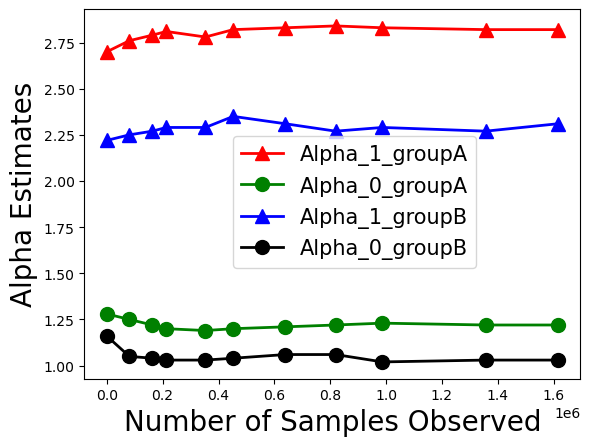

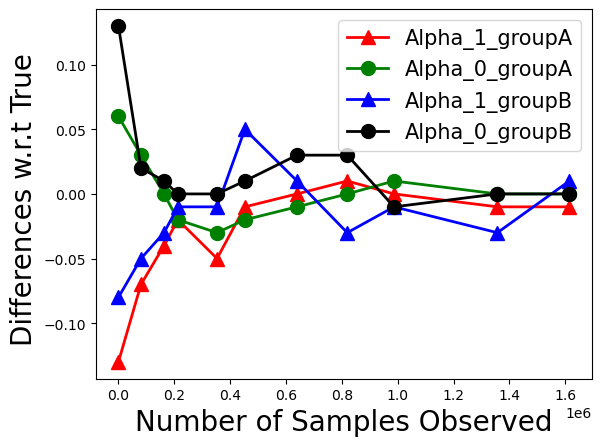

In [16]:
plt.plot(info['Alpha_1_group1'].dropna().index[:len(info['Alpha_1_group1'].dropna())-1],info['Alpha_1_group1'].dropna()[:len(info['Alpha_1_group1'].dropna())-1],
         lw=2,color='red',marker='^',ms=10, markevery=1,markerfacecolor='red')
plt.plot(info['Alpha_0_group1'].dropna().index[:len(info['Alpha_1_group1'].dropna())-1],info['Alpha_0_group1'].dropna()[:len(info['Alpha_0_group1'].dropna())-1],
         lw=2,color='green', marker='o',ms=10, markevery=1,markerfacecolor='green')
plt.plot(info['Alpha_1_group0'].dropna().index[:len(info['Alpha_1_group1'].dropna())-1],info['Alpha_1_group0'].dropna()[:len(info['Alpha_1_group0'].dropna())-1],
         lw=2,color='blue',marker='^',ms=10, markevery=1,markerfacecolor='blue')
plt.plot(info['Alpha_0_group0'].dropna().index[:len(info['Alpha_1_group1'].dropna())-1],info['Alpha_0_group0'].dropna()[:len(info['Alpha_0_group0'].dropna())-1],
         lw=2,color='black', marker='o',ms=10, markevery=1,markerfacecolor='black')
plt.legend(['Alpha_1_groupA','Alpha_0_groupA','Alpha_1_groupB','Alpha_0_groupB'],fontsize=15,loc=(0.3, 0.3))
#plt.title("Initial: $B^1_a$(1.83,3.32)/$B^0_a$(1.22,4.99); True: $B^1_a$(1.94,3.32)/$B^0_a$(1.13,4.99)",fontsize=15)
plt.xlabel('Number of Samples Observed', fontsize=20)
plt.ylabel('Alpha Estimates', fontsize=20)
plt.show()

plt.plot(info['Alpha_1_group1'].dropna().index,info['Alpha_1_group1'].dropna()[:len(info['Alpha_1_group1'].dropna())]-a1_true_group1,
         lw=4,color='red',marker='^',ms=12, markevery=1,markerfacecolor='red')
plt.plot(info['Alpha_0_group1'].dropna().index,info['Alpha_0_group1'].dropna()[:len(info['Alpha_0_group1'].dropna())]-a0_true_group1,
         lw=4,color='green', marker='o',ms=12, markevery=1,markerfacecolor='green')
plt.plot(info['Alpha_1_group0'].dropna().index,info['Alpha_1_group0'].dropna()[:len(info['Alpha_1_group0'].dropna())]-a1_true_group0,
         lw=4,color='blue',marker='^',ms=12, markevery=1,markerfacecolor='blue')
plt.plot(info['Alpha_0_group0'].dropna().index,info['Alpha_0_group0'].dropna()[:len(info['Alpha_0_group0'].dropna())]-a0_true_group0,
         lw=4,color='black', marker='o',ms=12, markevery=1,markerfacecolor='black')
plt.legend(['Alpha_1_groupA','Alpha_0_groupA','Alpha_1_groupB','Alpha_0_groupB'],fontsize=15)
plt.xlabel('Number of Samples Observed', fontsize=20)
plt.ylabel('Differences w.r.t True ', fontsize=20)
plt.show()


In [17]:
acc1 = np.array([0.7339018658884183,
  0.7391435221601347,
  0.7391813032108938,
  0.7391305155688898,
  0.7390735343120071,
  0.7395677847793153,
  0.7393572018734447,
  0.7386783816827556,
  0.7385769816780485,
  0.7393735343120071,
  0.7395672471735438])
acc2 = np.array([0.7339018658884183,
  0.737775352633463,
  0.7386783816827556,
  0.7386783816827556,
  0.7394631126878678,
  0.7386783816827556,
  0.7386783816827556,
  0.7393708278261775,
  0.7394305155688898,
  0.7396677450163078,
  0.7397275800431818])
acc3 = np.array([0.7339018658884183,
  0.7389100228792134,
  0.7379332898128661,
  0.7391819225723817,
  0.7393708278261775,
  0.7389100228792134,
  0.7386783816827556,
  0.7394631126878678,
  0.7392305155688898,
  0.7395783816827556,
  0.7397275800431818])
acc4 = np.array([0.7339018658884183,
  0.7383433071178261,
  0.7382677450163078,
  0.7385068185506198,
  0.7389100228792134,
  0.7389100228792134,
  0.7382677450163078,
  0.7393423371977361,
  0.7394100228792134,
  0.7395677450163078,
  0.7393677450163078])
acc5 = np.array([0.7339018658884183,
  0.737775352633463,
  0.7379332898128661,
  0.7395677847793153,
  0.7382677450163078,
  0.7395677847793153,
  0.7386783816827556,
  0.7393708278261775,
  0.7392735343120071,
  0.7392735343120071,
  0.7391332898128661])


In [18]:
fair1 = np.array([0.022964068531065307,
  0.00216622353456819,
  0.0014711607060353682,
  0.0025994742970765206,
  0.0043518477825096324,
  0.006167600107486293,
  0.005025058138277583,
  0.0026706378344339976,
  0.0073931445150657304,
  0.0043518477825096324,
  0.003952583415720136])
fair2 = np.array([0.022964068531065307,
  0.007387159892239259,
  0.0026706378344339976,
  0.0026706378344339976,
  0.0012406602542933687,
  0.0026706378344339976,
  0.0026706378344339976,
  0.001963958951548883,
  0.0025994742970765206,
  0.001063618580984027,
  0.004527370282102485])
fair3 = np.array([0.022964068531065307,
  0.0037318785761781825,
  0.0001417071424203442,
  0.00575942259111073,
  0.001963958951548883,
  0.0037318785761781825,
  0.0026706378344339976,
  0.0012406602542933687,
  0.0025994742970765206,
  0.0026706378344339976,
  0.003527370282102485])
fair4 = np.array([0.022964068531065307,
  0.01278889091780211,
  0.001063618580984027,
  0.004705164559114294,
  0.0037318785761781825,
  0.0037318785761781825,
  0.001063618580984027,
  0.006568027548842448,
  0.0037318785761781825,
  0.001063618580984027,
  0.001063618580984027])
fair5 = np.array([0.022964068531065307,
  0.007387159892239259,
  0.0001417071424203442,
  0.006167600107486293,
  0.001063618580984027,
  0.006167600107486293,
  0.0026706378344339976,
  0.001963958951548883,
  0.0043518477825096324,
  0.0043518477825096324,
  0.0011417071424203442])

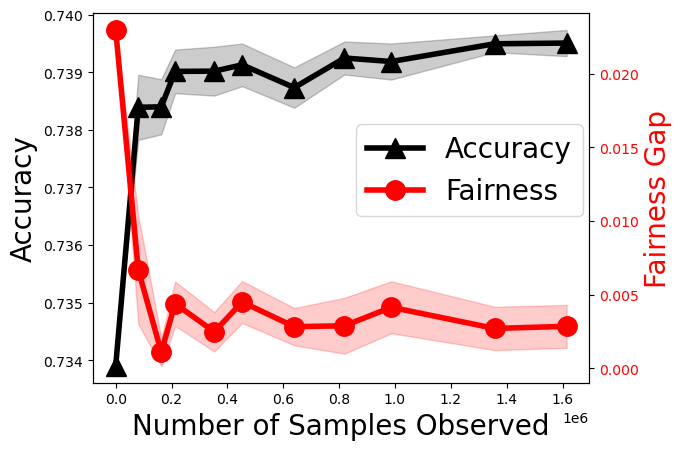

In [19]:
acc = np.mean([acc1, acc2, acc3, acc4, acc5], axis = 0)
acc_sd = np.std([acc1, acc2, acc3, acc4, acc5], axis = 0)

fair = np.mean([fair1, fair2, fair3, fair4, fair5], axis = 0)
fair_sd = np.std([fair1, fair2, fair3, fair4, fair5], axis = 0)

index = np.array([0, 80698, 163232, 212760, 353028, 452581, 639431, 819186, 986890, 1356804, 1614565])

fig, ax1 = plt.subplots()

# Plot accuracy on the primary y-axis
line1 = ax1.plot(index, acc, lw=4, color='black', marker='^', ms=14, markevery=1, markerfacecolor='black')
ax1.fill_between(index, acc - acc_sd, acc + acc_sd, color='black', alpha=0.2)  # Fill between accuracy lines
ax1.set_xlabel('Number of Samples Observed', fontsize=20)
ax1.set_ylabel('Accuracy', fontsize=20, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for fairness
ax2 = ax1.twinx()
line2 = ax2.plot(index, fair, lw=4, color='red', marker='o', ms=14, markevery=1, markerfacecolor='red')
ax2.fill_between(index, fair - fair_sd, fair + fair_sd, color='red', alpha=0.2)  # Fill between accuracy lines
ax2.set_ylabel('Fairness Gap', fontsize=20, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends for both lines
lines = line1 + line2
labels = ['Accuracy', 'Fairness']
plt.legend(lines, labels, fontsize=20, loc = (0.53,0.45))

plt.show()